In [1]:
%%capture
%matplotlib widget
#!pip install requests_cache

import matplotlib.pyplot as plt
import time
import requests
import pandas as pd
import numpy as np
import datetime
import math

import ipywidgets as widgets
from IPython.display import display, clear_output

import sys
sys.path.insert(1, '../python-scripts-c6fxKDJrSsWp1xCxON1Y7g')
sys.path.insert(1, '../../python-scripts-c6fxKDJrSsWp1xCxON1Y7g')
from api_calls import *

url = "https://nomad-hzb-ce.de/nomad-oasis/api/v1"

import os
token = os.environ['NOMAD_CLIENT_ACCESS_TOKEN']

In [53]:
def get_upload_names_from_main_authors(url, token, main_authors):   
    query = {
        'required': {
            'upload_id': '*',
        },
        'owner': 'visible',
        'query': {
            'origin:any': ['Marlena Thormeier'],
        },
        'pagination': {
            'page_size': 1000
        }
    }
    response = requests.post(f'{url}/entries/archive/query',
                             headers={'Authorization': f'Bearer {token}'}, json=query)
    linked_data = response.json()["data"]
    res = set()
    for ldata in linked_data:
        res.add(ldata.get('upload_id'))
    return res 


main_authors = ['Marlena Thormeier']

get_upload_names_for_user(url, token, main_authors)

{'0wMoq4kcR0qMCWHoQm5SzQ',
 '2iIKyoaEQaKGk_QUnKw0zQ',
 '2v58FpPsTKCRquu5VY3RpQ',
 'DnX7VmpYQw-7hbsV5_6ncw',
 'E2ks4EXSTyq63L586_q4lA',
 'EKzOifkORkOGFNMDP5mO6w',
 'ETjp6vRTQXarEXURK8PNwQ',
 'F8W5gV4yQ82Foh-e2OiAEQ',
 'IEOLThqHQsK9W-ZCLf04MA',
 'OOwCb2awSM-7BVPy4JokcA',
 'Pyr6u2DURdScWou42iJNww',
 'X8A2oIxKSNa5d7JuE2cJ1g',
 'edHH5RW8TDOM1UoPMsf6AQ',
 'igKCnSz8RSGWhFWFce6s6Q'}

In [54]:
# all widgets used in notebook
uploads = get_all_uploads(url, token, number_of_uploads=250)
upload_checkboxes = [widgets.Checkbox(value=False, description=upload.get('upload_name','--no-name--')) for upload in uploads]
scrollable_box = widgets.VBox(upload_checkboxes)
scrollable_area = widgets.Box([scrollable_box],
                              layout=widgets.Layout(
                                  overflow='scroll',
                                  border='1px solid gray',
                                  height='300px',
                                  width='600px',
                                  flex_flow='column',
                                  display='flex'
                              ))
select_uploads_button = widgets.Button(description='Confirm Selected Uploads', layout=widgets.Layout(width='600px',))
upload_selection_output = widgets.Output()

In [55]:
# widget logic
def save_selected_uploads(b):
    global upload_names, ca_data, cv_data
    upload_names = [cb.description for cb in upload_checkboxes if cb.value]
    with upload_selection_output:
        clear_output(wait=True)
        #print('Collecting CA and CV data from selected uploads. This can take a moment...')
        #ca_data = get_specific_entrytype_of_uploads(url, token, upload_names, 'CE_NOME_Chronoamperometry', with_meta=False)
        #cv_data = get_specific_entrytype_of_uploads(url, token, upload_names, 'CE_NOME_CyclicVoltammetry', with_meta=False)
        #clear_output(wait=True)
        print('Selected:', upload_names)
        #print('\nNumber of found CA files:', len(ca_data))
        #print('\nNumber of found CV files:', len(cv_data))

select_uploads_button.on_click(save_selected_uploads)

### Select Uploads

In [56]:
upload_names = []
display(scrollable_area, select_uploads_button, upload_selection_output)

Box(children=(VBox(children=(Checkbox(value=False, description='trial3_3_31thjuly'), Checkbox(value=False, des…

Button(description='Confirm Selected Uploads', layout=Layout(width='600px'), style=ButtonStyle())

Output()

In [5]:
# TODO remove this in production
upload_names = ['test data for summer student project']

### Create Table from NOMAD entries

In [6]:

#columns = ['sample_id', 'potential1 (mV vs RHE)', 'hold1 (s)', 'potential2 (mV vs RHE)', 'hold2 (s)', 'potential3 (mV vs RHE)', 'sweep speed (mV/s)', 'cycle (P2-P3)', 'duration (s)', 'duration (h)']
columns = ['upload_name', 'sample_id', 'potential1 (mV vs Hg/HgO)', 'hold1 (s)', 'potential2 (mV vs Hg/HgO)', 'hold2 (s)', 'potential3 (mV vs Hg/HgO)', 'sweep speed (mV/s)', 'cycle (P2-P3)', 'duration (s)', 'duration (h)']
rows = []
hold1 = 120
hold2 = 0
sweep_speed = 100

for upload_name in upload_names:
    try:
        ca_data = get_specific_entrytype_of_uploads(url, token, [upload_name], 'CE_NOME_Chronoamperometry', with_meta=False)
        cv_data = get_specific_entrytype_of_uploads(url, token, [upload_name], 'CE_NOME_CyclicVoltammetry', with_meta=False)

        sample_id = ca_data[0].get('samples')
    
        # extract data from Chronoamperometry files
        rhe = ca_data[0].get('voltage_shift') or -0.933     #TODO get this from calibration files
        potential1 = ca_data[0].get('properties').get('step_1_potential')
        potential1_rhe = potential1 - rhe
    
        # extract data from CyclicVoltammetry files
        rhe = cv_data[0].get('voltage_shift') or -0.933     #TODO get this from calibration files
        potential2 = cv_data[0].get('properties').get('limit_potential_1')
        potential3 = cv_data[0].get('properties').get('limit_potential_2')
        potential2_rhe = potential2 - rhe
        potential3_rhe = potential3 - rhe
     
        interval1 = hold1 + np.abs(potential1 - potential2)/sweep_speed
        interval2 = np.abs(potential2 - potential3)/sweep_speed + hold2
        cycles = min(50, math.floor((3600 - interval1) / interval2))
        #if cycles+1 != len(cv_data[0].get('cycles', [{}])):
        if cycles != cv_data[0].get('properties').get('cycles'):
            print(upload_name, "cycles do not match")
        duration = interval1 + cycles*interval2
    
        rows.append([upload_name, sample_id, potential1*1000, hold1, potential2*1000, hold2, potential3*1000, sweep_speed, cycles, duration, duration/3600])
    
        print(upload_name, f': {len(cv_data)} CV files, {len(ca_data)} CA files')
    except:
        print(upload_name, "didnt work")

result = pd.DataFrame(rows, columns=columns)
result

test data for summer student project : 1 CV files, 1 CA files


,upload_name,sample_id,potential1 (mV vs Hg/HgO),hold1 (s),potential2 (mV vs Hg/HgO),hold2 (s),potential3 (mV vs Hg/HgO),sweep speed (mV/s),cycle (P2-P3),duration (s),duration (h)
0,test data for summer student project,None,-100.0,120,0.0,0,100.0,100,50,120.051,0.033348


### Calculation of Targets

In [7]:
# TODO add calculation of targets
# criteria for evaluation:
# 1) min potential of CP at 500 mA/cm2, potential lower than untreated sample
# 2) min area under CV (should be equivalent to CP), area lower than untreated sample
# 3) min standard deviation of CP in 1)
# 4) min rms sum of (CV minus averaged CV)

# TODO add plots for parameter visualization

In [8]:
# TODO decide how table and activity is connected: everything in the same upload or match via sample ids?

In [29]:
# TODO change this
upload_names2 = ['CE-NOME_AmBu_240819_0002', 'CE-NOME_AmBu_240819_0002']

activity_columns = ['upload_name', 'cp_potential', 'cv_area_0', 'cv_area_1', 'cp_std', 'cv_rms_sum_0', 'cv_rms_sum_1']
activity_rows = []
for upload_name in upload_names2:
    try:
        cp_potential, cv_area, cp_std, cv_rms_sum = None, None, None, None
        cp_data = get_specific_entrytype_of_uploads(url, token, [upload_name], 'CE_NOME_Chronopotentiometry', with_meta=False)
        if len(cp_data) > 1:
            cp_data.sort(key=lambda x: datetime.datetime.strptime(x.get('datetime'), "%Y-%m-%dT%H:%M:%S.%f+00:00") if "." in x.get('datetime') else datetime.datetime.strptime(x.get('datetime'), "%Y-%m-%dT%H:%M:%S+00:00"))

            cp_voltage_list = cp_data[0].get('voltage')
            # TODO find CP at 500 mA/cm2
            min_cp = min(cp_voltage_list)
            cp_std = np.std(cp_voltage_list)

        cv_data = get_specific_entrytype_of_uploads(url, token, [upload_name], 'CE_NOME_CyclicVoltammetry', with_meta=False)
        if len(cv_data) > 1:
            cv_data.sort(key=lambda x: datetime.datetime.strptime(x.get('datetime'), "%Y-%m-%dT%H:%M:%S.%f+00:00") if "." in x.get('datetime') else datetime.datetime.strptime(x.get('datetime'), "%Y-%m-%dT%H:%M:%S+00:00"))

        cycle_data_0 = cv_data[0].get('cycles', [{}])[0]
        cycle_data_1 = cv_data[0].get('cycles', [{}])[1]
        cv_current_list = cycle_data_0.get('current') # TODO use current or current density or ...
        cv_voltage_list = cycle_data_0.get('voltage')
        cv_current_list_1 = cycle_data_1.get('current') # TODO use current or current density or ...
        cv_voltage_list_1 = cycle_data_1.get('voltage')
        scan_rate_mV = cv_data[0].get('properties').get('scan_rate')
        scan_rate = scan_rate_mV/1000
        cv_area_0 = np.trapz(cv_current_list, cv_voltage_list) / scan_rate
        cv_area_1 = np.trapz(cv_current_list_1, cv_voltage_list_1) / scan_rate

        # TODO average of each curve or avg of all curves?
        current_avg_0 = np.mean(cv_current_list)
        current_avg_1 = np.mean(cv_current_list_1)
        cv_rms_sum_0 = np.sqrt(np.sum(np.square(cv_current_list - current_avg_0)))
        cv_rms_sum_1 = np.sqrt(np.sum(np.square(cv_current_list_1 - current_avg_1)))
        
        activity_rows.append([upload_name, cp_potential, cv_area_0, cv_area_1, cp_std, cv_rms_sum_0, cv_rms_sum_1])
        print(upload_name)
    except:
        print(upload_name, "didnt work")

activity = pd.DataFrame(activity_rows, columns=activity_columns)
activity

CE-NOME_AmBu_240819_0002
CE-NOME_AmBu_240819_0002


,upload_name,cp_potential,cv_area_0,cv_area_1,cp_std,cv_rms_sum_0,cv_rms_sum_1
0,CE-NOME_AmBu_240819_0002,None,1557.210623,1481.429087,0.066313,699.171538,721.497733
1,CE-NOME_AmBu_240819_0002,None,1557.210623,1481.429087,0.066313,699.171538,721.497733


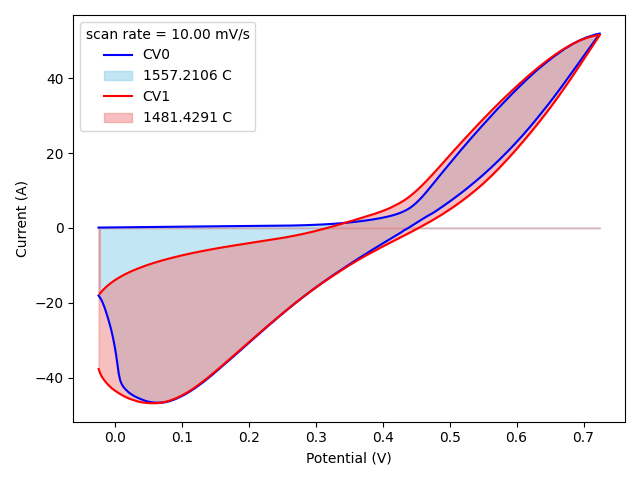

In [34]:
plt.figure()
plt.plot(cv_voltage_list, cv_current_list, label="CV0", color="blue")
plt.fill_between(cv_voltage_list, cv_current_list, color="skyblue", alpha=0.5, label=f"{cv_area_0:.4f} C")

plt.plot(cv_voltage_list_1, cv_current_list_1, label="CV1", color="red")
plt.fill_between(cv_voltage_list_1, cv_current_list_1, color="lightcoral", alpha=0.5, label=f"{cv_area_1:.4f} C")

plt.xlabel("Potential (V)")
plt.ylabel("Current (A)")
plt.legend(title=f'scan rate = {scan_rate*1000:.2f} mV/s')
#plt.grid(True)
plt.tight_layout()
plt.show()

### Save Data for Bayesian Optimization

In [10]:
date_now = datetime.datetime.now()
file_name = 'baybe_csv/nomad_result_table_ni_' + date_now.strftime("%Y%m%d") + '.csv'
result.to_csv(file_name, index=False)

In [11]:
rename_baybe = {
    'potential1 (mV vs Hg/HgO)': 'potential1',
    'potential2 (mV vs Hg/HgO)': 'potential2',
    'potential3 (mV vs Hg/HgO)': 'potential3',  
}
baybe_table = result.rename(columns=rename_baybe)[['potential1', 'potential2', 'potential3']]
import random 
baybe_table['Activity'] = range(1,len(result)+1) # TODO calculate this!!
baybe_table = baybe_table.replace('n/a', 0)    # this is from last year where sweep speed could be n/a TODO check if this is also possible this year
baybe_table.to_csv('baybe_csv/wateroxidation_ni.csv', index=False, header=True)
baybe_table

,potential1,potential2,potential3,Activity
0,-100.0,0.0,100.0,1
